# Examine CESM hindcast integrations

In [1]:
%matplotlib inline
import os
from glob import glob

from collections import OrderedDict

import xarray as xr
import numpy as np

import dask
import dask.distributed
try:
    import ncar_jobqueue
except:
    from dask_jobqueue import PBSCluster
    from distributed import Client

import esmlab

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [2]:
nmols_to_Pgyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

### Spin up a dask cluster

We are using `ncar_jobqueue.NCARCluster`; this just passes thru to `dask_jobqueue.PBSCluster` or `dask_jobqueue.SLURMCluster` depending on whether you are on Cheyenne or a DAV machine. 

**Note**: `dask_jobqueue.SLURMCluster` does not work on Cheyenne compute nodes, though the cluster jobs will start giving the appearance of functionality.

Default arguments to `ncar_jobqueue.NCARCluster` are set in `~/.config/dask/jobqueue.yaml`; you can over-ride these defaults by passing in arguments directly here.

In [3]:
try:
    cluster = ncar_jobqueue.NCARCluster()
    client = dask.distributed.Client(cluster)
except:
    cluster = PBSCluster(queue='premium', project='P93300606', cores=36, processes=9, memory='109GB')
    client = Client(cluster)

n_workers = 9 * 4
cluster.scale(n_workers)


/glade/work/mlevy/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "
/glade/work/mlevy/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


After the worker jobs have started, it's possible to view the client attributes.

In [ ]:
!qstat # | grep dask-worker

Paste the dashboard link into the `DASK DASHBOARD URL` in the `dask-labextension` at right, replacing the part that looks sort of IP-adress-ish with the URL in your browser, excluding the `/lab...` part.

In [4]:
client

Client Scheduler: tcp://10.148.10.19:43698 Dashboard: http://localhost:8888/proxy/57483/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Read the data from each case

In [5]:
cases = OrderedDict([
    ('g210.GECOIAF_JRA.gx1v7.C01', 'JRA'),
    ('g.e21.G1850ECOIAF.T62_g17.003', 'CORE')])
    
variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'TOT']]

ds_list = []
for case in cases.keys():
    print(f'reading {case}')
    droot = f'/glade/scratch/mlevy/archive/{case}/ocn/proc/tseries/month_1'

    dsc = xr.Dataset()
    for v in variables:
        files = sorted(glob(f'{droot}/{case}.pop.h.{v}.??????-??????.nc'))
        
        if not files:
            print(f'\tno files for {v}')
            # TODO: merge below will fail if not all cases have same vars
            #       need workaround
            
        dsv = xr.open_mfdataset(files, decode_times=False, decode_coords=False)
        dsc = xr.merge((dsc, dsv))

    ds_list.append(dsc)

# align dataset so that the time coordinate match:
# http://xarray.pydata.org/en/stable/generated/xarray.align.html#xarray.align
ds_list = xr.align(*ds_list, join='inner')

# concat along new case dim
case_dim = xr.DataArray(list(cases.values()), dims=('case'), 
                        coords={'case': list(cases.values())}, name='case')

ds = xr.concat(ds_list, dim=case_dim, data_vars=variables)

ds

reading g210.GECOIAF_JRA.gx1v7.C01
reading g.e21.G1850ECOIAF.T62_g17.003


<xarray.Dataset>
Dimensions:                 (case: 2, d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 624, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * case                    (case) <U4 'JRA' 'CORE'
  * time                    (time) float64 396.0 424.0 ... 1.931e+04 1.934e+04
  * z_t                     (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_t_150m                (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                     (z_w) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_top                 (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_bot                 (z_w_bot) float32 1000.0 2000.0 ... 549999.06
  * lat_aux_grid            (lat_aux_grid) float32 -79.48815 -78.952896 ... 90.0
  * moc_z                   (moc_z) float32 0.0 1000.0 ... 525000.94 549999.06
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, tr

### Compute global means

In [6]:
ds_glb = xr.Dataset({v: ds[v] for v in ['time', 'time_bound']})
for v in variables:
    ds_glb[v] = esmlab.weighted_sum(ds[v], weights=ds.TAREA, dim=['nlat', 'nlon'])
    ds_glb[v].attrs = ds[v].attrs

    if ds[v].units == 'mmol/m^3 cm/s':
        ds_glb[v] = ds_glb[v] * nmols_to_Pgyr        
        ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

# compute the dataset: this executes the task graph and loads the data into memory
ds_glb = ds_glb.compute()
ds_glb

<xarray.Dataset>
Dimensions:           (case: 2, d2: 2, time: 624)
Coordinates:
  * time              (time) float64 396.0 424.0 455.0 ... 1.931e+04 1.934e+04
  * case              (case) <U4 'JRA' 'CORE'
Dimensions without coordinates: d2
Data variables:
    time_bound        (time, d2) float64 365.1 396.0 ... 1.931e+04 1.934e+04
    photoC_diat_zint  (case, time) float64 17.76 14.78 12.92 ... 16.07 16.15
    photoC_sp_zint    (case, time) float64 36.23 31.88 30.13 ... 40.77 39.89
    photoC_diaz_zint  (case, time) float64 1.688 1.831 1.863 ... 1.605 1.607
    photoC_TOT_zint   (case, time) float64 55.68 48.49 44.92 ... 58.44 57.64

### Compute annual means

In [7]:
ds_glb_ann = esmlab.resample(ds_glb, freq='ann')
ds_glb_ann

<xarray.Dataset>
Dimensions:           (case: 2, d2: 2, time: 52)
Coordinates:
  * case              (case) object 'JRA' 'CORE'
  * time              (time) float64 546.7 911.7 ... 1.88e+04 1.916e+04
Dimensions without coordinates: d2
Data variables:
    time_bound        (d2, time) float64 365.1 730.0 ... 1.898e+04 1.934e+04
    photoC_diat_zint  (case, time) float64 16.32 14.82 14.97 ... 15.11 16.86
    photoC_sp_zint    (case, time) float64 29.87 30.71 31.04 ... 33.93 32.97
    photoC_diaz_zint  (case, time) float64 1.799 1.78 1.732 ... 1.705 1.658
    photoC_TOT_zint   (case, time) float64 47.99 47.32 47.74 ... 50.74 51.49
Attributes:
    history:  \n2019-05-02 13:29:25.405267 esmlab.resample(<DATASET>, freq="a...

### Make some timeseries plots

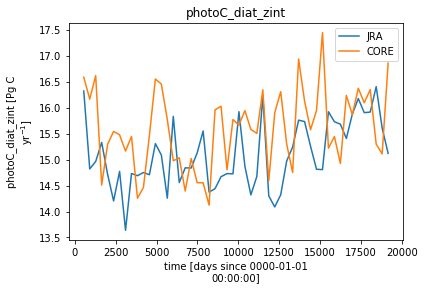

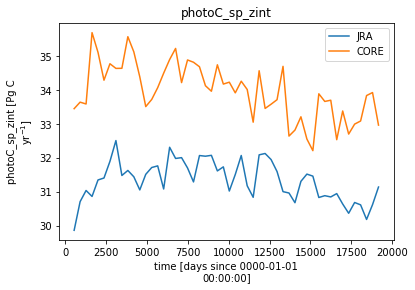

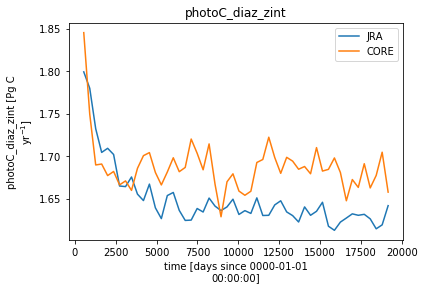

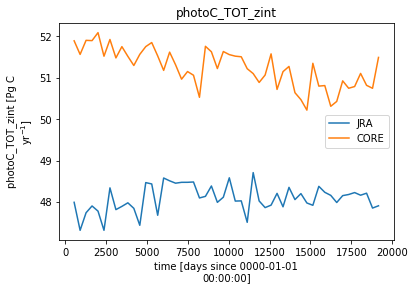

In [8]:
for v in variables:
    fig = plt.figure()
    for case in ds.case.values:
        ds_glb_ann[v].sel(case=case).plot(label=case)
    plt.title(v)
    plt.legend()